In [1]:
import pandas as pd
import os


def load_data(path):
    x_train, y_train, x_valid, y_valid= [], [], [], []
    for types in os.listdir(path):
        classes_path = f'{path}/{types}'
        for classes in os.listdir(classes_path):
            file_path = f'{classes_path}/{classes}'
            df = pd.read_csv(file_path).values
            input_text, summary = df[:,1], df[:,0]
            if types == 'Train':
                x_train.extend(input_text)
                y_train.extend(summary)
            
            else:
                x_valid.extend(input_text)
                y_valid.extend(summary)
    return  x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = load_data('SummaryData')

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter


def get_vocab(inputs, tokenizer, train_len, special = ('<PAD>', '<SOS>','<EOS>','<UNK>')):
    counter = Counter()


    new_inputs = []
    for sentence in inputs:
        tokens = tokenizer(sentence)
        counter.update(tokens)
        new_inputs.append(tokens)

    token_vocab = vocab(counter, min_freq=5, specials=special)

    return token_vocab, new_inputs[:train_len], new_inputs[train_len:]

all_input = x_train + x_valid
all_target = y_train + y_valid
tokenizer = get_tokenizer('basic_english')

input_vocab, x_train, x_valid= get_vocab(all_input, tokenizer, len(x_train))
traget_vocab, y_train, y_valid= get_vocab(all_target, tokenizer, len(y_train))





input_vocab.set_default_index(input_vocab.get_stoi()['<UNK>'])
traget_vocab.set_default_index(traget_vocab.get_stoi()['<UNK>'])

# Ecoder與Decoder的Embedding輸入大小
INPUT_DIM =  len(input_vocab)
OUTPUT_DIN = len(traget_vocab)

# 取得給予模型的索引值
SOS_IDX = input_vocab.get_stoi()['<SOS>']
EOS_IDX = input_vocab.get_stoi()['<EOS>']
PAD_IDX = input_vocab.get_stoi()['<PAD>']

In [3]:
import torch

def token2num(inputs, targets):
    encoder_input, decoder_input = [], []
    for i in range(len(inputs)):
        encoder_in = input_vocab.lookup_indices(inputs[i])[:499] + [EOS_IDX]
        decoder_in = traget_vocab.lookup_indices(targets[i])[:499] + [EOS_IDX]

        encoder_input.append(torch.tensor(encoder_in))
        decoder_input.append(torch.tensor(decoder_in))
    return encoder_input, decoder_input

x_train, y_train= token2num(x_train, y_train)
x_valid, y_valid= token2num(x_valid, y_valid)

In [4]:
from torch.utils.data import Dataset, DataLoader

class SummaryeDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = SummaryeDataset(x_train, y_train)
validset = SummaryeDataset(x_valid, y_valid)

In [5]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):    
    (x, y) = zip(*batch)
    
    pad_data = pad_sequence(x + y, padding_value=PAD_IDX, batch_first=True)
    src, tgt = torch.split(pad_data, split_size_or_sections=[len(x), len(y)], dim=0)

  

    return src.permute(1, 0) , tgt.permute(1, 0)
train_loader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True, collate_fn = collate_fn)
valid_loader = DataLoader(validset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True, collate_fn = collate_fn)


In [6]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 500):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)
    

class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int,  # Encoder數量
                 num_decoder_layers: int,        # Decoder數量
                 emb_size: int,                  # Embedding輸出
                 nhead: int,                     # head的數量
                 src_vocab_size: int,            # Encoder Embedding大小
                 tgt_vocab_size: int,            # Deocder Embedding大小
                 dim_feedforward: int = 512,     # feedforward神經元數量
                 dropout: float = 0.1            # 每層丟棄多少神經元
            ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,         # Encoder輸入
                trg: Tensor,         # Decoder輸入
                src_mask: Tensor,    # Encoder輸入忽略PAD_IDX的索引
                tgt_mask: Tensor,    # Decoder輸入忽略PAD_IDX的索引
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [7]:
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, INPUT_DIM, OUTPUT_DIN, FFN_HID_DIM)



model = transformer.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt 

def train(epoch):
    train_loss = 0
    train_pbar = tqdm(train_loader, position=0, leave=True) 

    model.train()
    for input_datas in train_pbar: 
        
        src, tgt = [i.to(device) for i in input_datas]
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()
        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()

        train_pbar.set_description(f'Train Epoch {epoch}')  
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) 

        train_loss += loss.item()

    return train_loss/len(train_loader)

def valid(epoch):
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True) 

    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar: 
            
            src, tgt = [i.to(device) for i in input_datas]

            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:, :]
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

            valid_pbar.set_description(f'Valid Epoch {epoch}')  
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'}) 
    
            valid_loss += loss.item()
    
        return valid_loss/len(valid_loader)
    
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

  0%|          | 0/2867 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Valid Epoch 0: 100%|██████████| 3556/3556 [00:56<00:00, 63.39it/s, loss=8.062]


Saving Model With Loss 7.82280
Train Loss: 7.47472| Valid Loss: 7.82280| Best Loss: 7.82280



Valid Epoch 1: 100%|██████████| 3556/3556 [00:55<00:00, 63.53it/s, loss=7.316]


Saving Model With Loss 7.43181
Train Loss: 6.83756| Valid Loss: 7.43181| Best Loss: 7.43181



Valid Epoch 2: 100%|██████████| 3556/3556 [00:55<00:00, 63.74it/s, loss=7.263]


Saving Model With Loss 7.15172
Train Loss: 6.47267| Valid Loss: 7.15172| Best Loss: 7.15172



Valid Epoch 3: 100%|██████████| 3556/3556 [00:56<00:00, 63.48it/s, loss=6.894]


Saving Model With Loss 6.97456
Train Loss: 6.18011| Valid Loss: 6.97456| Best Loss: 6.97456



Valid Epoch 4: 100%|██████████| 3556/3556 [00:56<00:00, 63.02it/s, loss=6.755]


Saving Model With Loss 6.86287
Train Loss: 5.92162| Valid Loss: 6.86287| Best Loss: 6.86287



Valid Epoch 5: 100%|██████████| 3556/3556 [00:55<00:00, 63.52it/s, loss=6.773]


Saving Model With Loss 6.58602
Train Loss: 5.69394| Valid Loss: 6.58602| Best Loss: 6.58602



Valid Epoch 6: 100%|██████████| 3556/3556 [00:55<00:00, 63.71it/s, loss=6.209]


Saving Model With Loss 6.45817
Train Loss: 5.48100| Valid Loss: 6.45817| Best Loss: 6.45817



Valid Epoch 7: 100%|██████████| 3556/3556 [00:55<00:00, 63.80it/s, loss=6.175]


Saving Model With Loss 6.32319
Train Loss: 5.28912| Valid Loss: 6.32319| Best Loss: 6.32319



Valid Epoch 8: 100%|██████████| 3556/3556 [00:55<00:00, 63.58it/s, loss=6.932]


Saving Model With Loss 6.28203
Train Loss: 5.10661| Valid Loss: 6.28203| Best Loss: 6.28203



Valid Epoch 9: 100%|██████████| 3556/3556 [00:55<00:00, 63.77it/s, loss=6.041]


Saving Model With Loss 6.16706
Train Loss: 4.93967| Valid Loss: 6.16706| Best Loss: 6.16706



Valid Epoch 10: 100%|██████████| 3556/3556 [00:54<00:00, 65.70it/s, loss=6.153]


Saving Model With Loss 6.05932
Train Loss: 4.78238| Valid Loss: 6.05932| Best Loss: 6.05932



Valid Epoch 11: 100%|██████████| 3556/3556 [00:56<00:00, 63.46it/s, loss=6.564]


Train Loss: 4.63378| Valid Loss: 6.09231| Best Loss: 6.05932



Valid Epoch 12: 100%|██████████| 3556/3556 [00:54<00:00, 64.91it/s, loss=5.723]


Saving Model With Loss 5.87732
Train Loss: 4.49703| Valid Loss: 5.87732| Best Loss: 5.87732



Valid Epoch 13: 100%|██████████| 3556/3556 [00:54<00:00, 64.75it/s, loss=4.940]


Saving Model With Loss 5.85204
Train Loss: 4.36233| Valid Loss: 5.85204| Best Loss: 5.85204



Valid Epoch 14: 100%|██████████| 3556/3556 [00:54<00:00, 65.03it/s, loss=5.101]


Saving Model With Loss 5.68538
Train Loss: 4.24094| Valid Loss: 5.68538| Best Loss: 5.68538



Valid Epoch 15: 100%|██████████| 3556/3556 [00:55<00:00, 63.77it/s, loss=5.826]


Saving Model With Loss 5.67410
Train Loss: 4.12021| Valid Loss: 5.67410| Best Loss: 5.67410



Valid Epoch 16: 100%|██████████| 3556/3556 [00:54<00:00, 65.01it/s, loss=5.757]


Train Loss: 4.01201| Valid Loss: 5.67837| Best Loss: 5.67410



Valid Epoch 17: 100%|██████████| 3556/3556 [00:54<00:00, 64.95it/s, loss=5.864]


Saving Model With Loss 5.60897
Train Loss: 3.90704| Valid Loss: 5.60897| Best Loss: 5.60897



Valid Epoch 18: 100%|██████████| 3556/3556 [00:54<00:00, 64.87it/s, loss=5.899]


Train Loss: 3.80917| Valid Loss: 5.65104| Best Loss: 5.60897



Valid Epoch 19: 100%|██████████| 3556/3556 [00:54<00:00, 65.15it/s, loss=5.482]


Train Loss: 3.71637| Valid Loss: 5.63986| Best Loss: 5.60897



Valid Epoch 20: 100%|██████████| 3556/3556 [00:54<00:00, 65.15it/s, loss=5.682]


Saving Model With Loss 5.52176
Train Loss: 3.62857| Valid Loss: 5.52176| Best Loss: 5.52176



Valid Epoch 21: 100%|██████████| 3556/3556 [00:54<00:00, 65.25it/s, loss=6.118]


Train Loss: 3.54738| Valid Loss: 5.57374| Best Loss: 5.52176



Valid Epoch 22: 100%|██████████| 3556/3556 [00:54<00:00, 64.77it/s, loss=6.314]


Train Loss: 3.47134| Valid Loss: 5.52224| Best Loss: 5.52176



Valid Epoch 23: 100%|██████████| 3556/3556 [00:54<00:00, 65.14it/s, loss=5.526]


Saving Model With Loss 5.44311
Train Loss: 3.40284| Valid Loss: 5.44311| Best Loss: 5.44311



Valid Epoch 24: 100%|██████████| 3556/3556 [00:54<00:00, 65.00it/s, loss=6.923]


Train Loss: 3.34280| Valid Loss: 5.49964| Best Loss: 5.44311



Valid Epoch 25: 100%|██████████| 3556/3556 [00:54<00:00, 65.01it/s, loss=4.847]


Train Loss: 3.28963| Valid Loss: 5.49888| Best Loss: 5.44311



Valid Epoch 26: 100%|██████████| 3556/3556 [00:54<00:00, 64.99it/s, loss=5.594]


Train Loss: 3.24969| Valid Loss: 5.55361| Best Loss: 5.44311



Valid Epoch 27: 100%|██████████| 3556/3556 [00:54<00:00, 65.06it/s, loss=6.530]


Train Loss: 3.22755| Valid Loss: 5.49053| Best Loss: 5.44311



Valid Epoch 28: 100%|██████████| 3556/3556 [00:54<00:00, 65.07it/s, loss=4.849]


Train Loss: 3.21705| Valid Loss: 5.50293| Best Loss: 5.44311



Valid Epoch 29: 100%|██████████| 3556/3556 [00:55<00:00, 64.13it/s, loss=5.096]


Saving Model With Loss 5.36531
Train Loss: 3.19472| Valid Loss: 5.36531| Best Loss: 5.36531



Valid Epoch 30: 100%|██████████| 3556/3556 [00:55<00:00, 64.35it/s, loss=5.324]


Saving Model With Loss 5.13791
Train Loss: 3.15366| Valid Loss: 5.13791| Best Loss: 5.13791



Valid Epoch 31: 100%|██████████| 3556/3556 [00:55<00:00, 63.64it/s, loss=4.621]


Saving Model With Loss 5.11865
Train Loss: 3.10548| Valid Loss: 5.11865| Best Loss: 5.11865



Valid Epoch 32: 100%|██████████| 3556/3556 [00:56<00:00, 63.48it/s, loss=6.248]


Train Loss: 3.05685| Valid Loss: 5.11944| Best Loss: 5.11865



Valid Epoch 33: 100%|██████████| 3556/3556 [00:56<00:00, 63.46it/s, loss=5.419]


Saving Model With Loss 5.01773
Train Loss: 3.01121| Valid Loss: 5.01773| Best Loss: 5.01773



Valid Epoch 34: 100%|██████████| 3556/3556 [00:56<00:00, 63.27it/s, loss=5.137]


Saving Model With Loss 4.97087
Train Loss: 2.96779| Valid Loss: 4.97087| Best Loss: 4.97087



Valid Epoch 35: 100%|██████████| 3556/3556 [00:55<00:00, 64.09it/s, loss=5.254]


Saving Model With Loss 4.96915
Train Loss: 2.92747| Valid Loss: 4.96915| Best Loss: 4.96915



Valid Epoch 36: 100%|██████████| 3556/3556 [00:55<00:00, 63.61it/s, loss=4.764]


Saving Model With Loss 4.85003
Train Loss: 2.88984| Valid Loss: 4.85003| Best Loss: 4.85003



Valid Epoch 37: 100%|██████████| 3556/3556 [00:55<00:00, 63.63it/s, loss=4.325]


Train Loss: 2.85529| Valid Loss: 4.86428| Best Loss: 4.85003



Valid Epoch 38: 100%|██████████| 3556/3556 [00:56<00:00, 63.31it/s, loss=5.092]


Saving Model With Loss 4.73501
Train Loss: 2.82221| Valid Loss: 4.73501| Best Loss: 4.73501



Valid Epoch 39: 100%|██████████| 3556/3556 [00:56<00:00, 63.45it/s, loss=5.321]


Train Loss: 2.79217| Valid Loss: 4.81007| Best Loss: 4.73501



Valid Epoch 40: 100%|██████████| 3556/3556 [00:55<00:00, 63.81it/s, loss=5.135]


Train Loss: 2.76562| Valid Loss: 4.80441| Best Loss: 4.73501



Valid Epoch 41: 100%|██████████| 3556/3556 [00:55<00:00, 63.99it/s, loss=4.672]


Train Loss: 2.74185| Valid Loss: 4.74916| Best Loss: 4.73501



Valid Epoch 42: 100%|██████████| 3556/3556 [00:55<00:00, 63.83it/s, loss=4.173]


Saving Model With Loss 4.69784
Train Loss: 2.71436| Valid Loss: 4.69784| Best Loss: 4.69784



Valid Epoch 43: 100%|██████████| 3556/3556 [00:55<00:00, 64.05it/s, loss=3.908]


Saving Model With Loss 4.61282
Train Loss: 2.69325| Valid Loss: 4.61282| Best Loss: 4.61282



Valid Epoch 44: 100%|██████████| 3556/3556 [00:54<00:00, 64.94it/s, loss=4.774]


Train Loss: 2.67546| Valid Loss: 4.71296| Best Loss: 4.61282



Valid Epoch 45: 100%|██████████| 3556/3556 [00:55<00:00, 64.58it/s, loss=4.187]


Train Loss: 2.65636| Valid Loss: 4.67263| Best Loss: 4.61282



Valid Epoch 46: 100%|██████████| 3556/3556 [00:54<00:00, 64.78it/s, loss=4.448]


Train Loss: 2.63874| Valid Loss: 4.71412| Best Loss: 4.61282



Valid Epoch 47: 100%|██████████| 3556/3556 [00:54<00:00, 64.90it/s, loss=4.822]


Saving Model With Loss 4.54595
Train Loss: 2.62423| Valid Loss: 4.54595| Best Loss: 4.54595



Valid Epoch 48: 100%|██████████| 3556/3556 [00:54<00:00, 64.94it/s, loss=4.325]


Train Loss: 2.60709| Valid Loss: 4.62882| Best Loss: 4.54595



Valid Epoch 49: 100%|██████████| 3556/3556 [00:54<00:00, 65.17it/s, loss=4.410]


Saving Model With Loss 4.53364
Train Loss: 2.59269| Valid Loss: 4.53364| Best Loss: 4.53364



Valid Epoch 50: 100%|██████████| 3556/3556 [00:54<00:00, 64.73it/s, loss=5.195]


Train Loss: 2.57558| Valid Loss: 4.55948| Best Loss: 4.53364



Valid Epoch 51: 100%|██████████| 3556/3556 [00:54<00:00, 65.27it/s, loss=3.694]


Train Loss: 2.56429| Valid Loss: 4.57703| Best Loss: 4.53364



Valid Epoch 52: 100%|██████████| 3556/3556 [00:54<00:00, 65.33it/s, loss=5.181]


Saving Model With Loss 4.49462
Train Loss: 2.54777| Valid Loss: 4.49462| Best Loss: 4.49462



Valid Epoch 53: 100%|██████████| 3556/3556 [00:54<00:00, 65.00it/s, loss=4.418]


Train Loss: 2.53343| Valid Loss: 4.53966| Best Loss: 4.49462



Valid Epoch 54: 100%|██████████| 3556/3556 [00:54<00:00, 64.69it/s, loss=4.325]


Saving Model With Loss 4.45906
Train Loss: 2.51890| Valid Loss: 4.45906| Best Loss: 4.45906



Valid Epoch 55: 100%|██████████| 3556/3556 [00:55<00:00, 64.65it/s, loss=4.355]


Train Loss: 2.50956| Valid Loss: 4.52469| Best Loss: 4.45906



Valid Epoch 56: 100%|██████████| 3556/3556 [00:54<00:00, 64.76it/s, loss=4.170]


Saving Model With Loss 4.45755
Train Loss: 2.49591| Valid Loss: 4.45755| Best Loss: 4.45755



Valid Epoch 57: 100%|██████████| 3556/3556 [00:54<00:00, 64.92it/s, loss=3.585]


Train Loss: 2.47994| Valid Loss: 4.46010| Best Loss: 4.45755



Valid Epoch 58: 100%|██████████| 3556/3556 [00:54<00:00, 64.77it/s, loss=4.470]


Saving Model With Loss 4.45549
Train Loss: 2.46636| Valid Loss: 4.45549| Best Loss: 4.45549



Valid Epoch 59: 100%|██████████| 3556/3556 [00:55<00:00, 64.59it/s, loss=4.047]


Train Loss: 2.45647| Valid Loss: 4.45834| Best Loss: 4.45549



Valid Epoch 60: 100%|██████████| 3556/3556 [00:55<00:00, 63.74it/s, loss=4.658]


Saving Model With Loss 4.43679
Train Loss: 2.44529| Valid Loss: 4.43679| Best Loss: 4.43679



Valid Epoch 61: 100%|██████████| 3556/3556 [00:55<00:00, 63.64it/s, loss=4.944]


Saving Model With Loss 4.40805
Train Loss: 2.43460| Valid Loss: 4.40805| Best Loss: 4.40805



Valid Epoch 62: 100%|██████████| 3556/3556 [00:55<00:00, 64.00it/s, loss=4.571]


Saving Model With Loss 4.32078
Train Loss: 2.42406| Valid Loss: 4.32078| Best Loss: 4.32078



Valid Epoch 63: 100%|██████████| 3556/3556 [00:56<00:00, 63.25it/s, loss=4.396]


Train Loss: 2.41425| Valid Loss: 4.39871| Best Loss: 4.32078



Valid Epoch 64: 100%|██████████| 3556/3556 [00:56<00:00, 63.38it/s, loss=4.715]


Train Loss: 2.40356| Valid Loss: 4.33029| Best Loss: 4.32078



Valid Epoch 65: 100%|██████████| 3556/3556 [00:56<00:00, 63.07it/s, loss=4.267]


Train Loss: 2.39642| Valid Loss: 4.35055| Best Loss: 4.32078



Valid Epoch 66: 100%|██████████| 3556/3556 [00:56<00:00, 63.12it/s, loss=4.609]


Train Loss: 2.38303| Valid Loss: 4.38749| Best Loss: 4.32078



Valid Epoch 67: 100%|██████████| 3556/3556 [00:56<00:00, 63.11it/s, loss=3.777]


Train Loss: 2.37148| Valid Loss: 4.36404| Best Loss: 4.32078



Valid Epoch 68: 100%|██████████| 3556/3556 [00:55<00:00, 63.90it/s, loss=3.665]


Train Loss: 2.36075| Valid Loss: 4.32749| Best Loss: 4.32078



Valid Epoch 69: 100%|██████████| 3556/3556 [00:55<00:00, 63.84it/s, loss=5.044]


Train Loss: 2.35539| Valid Loss: 4.36261| Best Loss: 4.32078



Valid Epoch 70: 100%|██████████| 3556/3556 [00:56<00:00, 63.47it/s, loss=3.428]


Train Loss: 2.34019| Valid Loss: 4.35852| Best Loss: 4.32078



Valid Epoch 71: 100%|██████████| 3556/3556 [00:54<00:00, 64.87it/s, loss=5.398]


Saving Model With Loss 4.26806
Train Loss: 2.33394| Valid Loss: 4.26806| Best Loss: 4.26806



Valid Epoch 72: 100%|██████████| 3556/3556 [00:56<00:00, 63.44it/s, loss=4.700]


Train Loss: 2.32244| Valid Loss: 4.30021| Best Loss: 4.26806



Valid Epoch 73: 100%|██████████| 3556/3556 [00:56<00:00, 63.13it/s, loss=4.464]


Saving Model With Loss 4.25576
Train Loss: 2.32014| Valid Loss: 4.25576| Best Loss: 4.25576



Valid Epoch 74: 100%|██████████| 3556/3556 [00:56<00:00, 63.37it/s, loss=3.891]


Train Loss: 2.30847| Valid Loss: 4.27436| Best Loss: 4.25576



Valid Epoch 75: 100%|██████████| 3556/3556 [00:56<00:00, 63.06it/s, loss=3.517]


Train Loss: 2.29583| Valid Loss: 4.31537| Best Loss: 4.25576



Valid Epoch 76: 100%|██████████| 3556/3556 [00:55<00:00, 63.74it/s, loss=4.157]


Train Loss: 2.29324| Valid Loss: 4.32257| Best Loss: 4.25576



Valid Epoch 77: 100%|██████████| 3556/3556 [00:55<00:00, 64.25it/s, loss=5.379]


Saving Model With Loss 4.24138
Train Loss: 2.28620| Valid Loss: 4.24138| Best Loss: 4.24138



Valid Epoch 78: 100%|██████████| 3556/3556 [00:55<00:00, 64.04it/s, loss=5.755]


Train Loss: 2.27280| Valid Loss: 4.28188| Best Loss: 4.24138



Valid Epoch 79: 100%|██████████| 3556/3556 [00:55<00:00, 63.67it/s, loss=4.386]


Saving Model With Loss 4.16570
Train Loss: 2.27026| Valid Loss: 4.16570| Best Loss: 4.16570



Valid Epoch 80: 100%|██████████| 3556/3556 [00:54<00:00, 65.52it/s, loss=2.660]


Train Loss: 2.25966| Valid Loss: 4.24462| Best Loss: 4.16570



Valid Epoch 81: 100%|██████████| 3556/3556 [00:55<00:00, 64.00it/s, loss=3.980]


Train Loss: 2.24863| Valid Loss: 4.17864| Best Loss: 4.16570



Valid Epoch 82: 100%|██████████| 3556/3556 [00:54<00:00, 65.59it/s, loss=3.906]


Train Loss: 2.24276| Valid Loss: 4.21143| Best Loss: 4.16570



Valid Epoch 83: 100%|██████████| 3556/3556 [00:54<00:00, 65.43it/s, loss=4.411]


Train Loss: 2.23574| Valid Loss: 4.20341| Best Loss: 4.16570



Valid Epoch 84: 100%|██████████| 3556/3556 [00:54<00:00, 65.63it/s, loss=4.337]


Train Loss: 2.22905| Valid Loss: 4.18887| Best Loss: 4.16570



Valid Epoch 85: 100%|██████████| 3556/3556 [00:54<00:00, 65.52it/s, loss=4.156]


Train Loss: 2.22261| Valid Loss: 4.22789| Best Loss: 4.16570



Valid Epoch 86: 100%|██████████| 3556/3556 [00:54<00:00, 65.66it/s, loss=3.579]


Saving Model With Loss 4.11416
Train Loss: 2.21254| Valid Loss: 4.11416| Best Loss: 4.11416



Valid Epoch 87: 100%|██████████| 3556/3556 [00:54<00:00, 65.10it/s, loss=4.685]


Train Loss: 2.20340| Valid Loss: 4.27483| Best Loss: 4.11416



Valid Epoch 88: 100%|██████████| 3556/3556 [00:54<00:00, 65.28it/s, loss=4.100]


Train Loss: 2.19984| Valid Loss: 4.12377| Best Loss: 4.11416



Valid Epoch 89: 100%|██████████| 3556/3556 [00:54<00:00, 65.13it/s, loss=4.079]


Train Loss: 2.19024| Valid Loss: 4.13729| Best Loss: 4.11416



Valid Epoch 90: 100%|██████████| 3556/3556 [00:55<00:00, 64.03it/s, loss=5.419]


Train Loss: 2.18660| Valid Loss: 4.14175| Best Loss: 4.11416



Valid Epoch 91: 100%|██████████| 3556/3556 [00:55<00:00, 64.43it/s, loss=4.306]


Saving Model With Loss 4.07427
Train Loss: 2.17954| Valid Loss: 4.07427| Best Loss: 4.07427



Valid Epoch 92: 100%|██████████| 3556/3556 [00:55<00:00, 63.72it/s, loss=5.537]


Train Loss: 2.16890| Valid Loss: 4.16452| Best Loss: 4.07427



Valid Epoch 93: 100%|██████████| 3556/3556 [00:55<00:00, 64.31it/s, loss=3.451]


Train Loss: 2.16351| Valid Loss: 4.09844| Best Loss: 4.07427



Valid Epoch 94: 100%|██████████| 3556/3556 [00:55<00:00, 63.93it/s, loss=4.263]


Train Loss: 2.15276| Valid Loss: 4.13003| Best Loss: 4.07427



Valid Epoch 95: 100%|██████████| 3556/3556 [00:54<00:00, 65.07it/s, loss=5.061]


Train Loss: 2.15221| Valid Loss: 4.14299| Best Loss: 4.07427



Valid Epoch 96: 100%|██████████| 3556/3556 [00:54<00:00, 64.66it/s, loss=3.416]


Saving Model With Loss 4.05970
Train Loss: 2.14481| Valid Loss: 4.05970| Best Loss: 4.05970



Valid Epoch 97: 100%|██████████| 3556/3556 [00:55<00:00, 64.61it/s, loss=3.741]


Saving Model With Loss 4.05096
Train Loss: 2.14159| Valid Loss: 4.05096| Best Loss: 4.05096



Valid Epoch 98: 100%|██████████| 3556/3556 [00:54<00:00, 64.95it/s, loss=3.663]


Train Loss: 2.13378| Valid Loss: 4.10571| Best Loss: 4.05096



Valid Epoch 99: 100%|██████████| 3556/3556 [00:54<00:00, 65.11it/s, loss=3.034]


Train Loss: 2.12309| Valid Loss: 4.10222| Best Loss: 4.05096



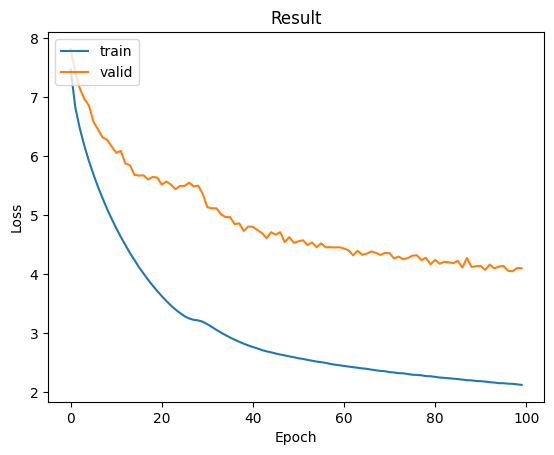

In [10]:
epochs = 100                             # 訓練次數
early_stopping = 10                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                 # 最佳的Loss
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss = train(epoch)
    valid_loss = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'e' + model_path)
        print(f'Saving Model With Loss {best_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f}' , end='| ')
    print(f'Valid Loss: {valid_loss:.5f}' , end='| ')
    print(f'Best Loss: {best_loss:.5f}', end='\n\n')


if show_loss:
    show_training_loss(loss_record)